<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/11_Febrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo CSV cargado exitosamente.
Número de puntos en la señal: 301
Frecuencia de muestreo: 1000.0000 Hz
Frecuencia mínima de la señal original: 3.3223 Hz
Frecuencia máxima de la señal original: 498.3389 Hz
Ingresa la frecuencia mínima (Hz) a filtrar: 30
Ingresa la frecuencia máxima (Hz) a filtrar: 330
Filtro seleccionado: de 30.0 Hz a 330.0 Hz


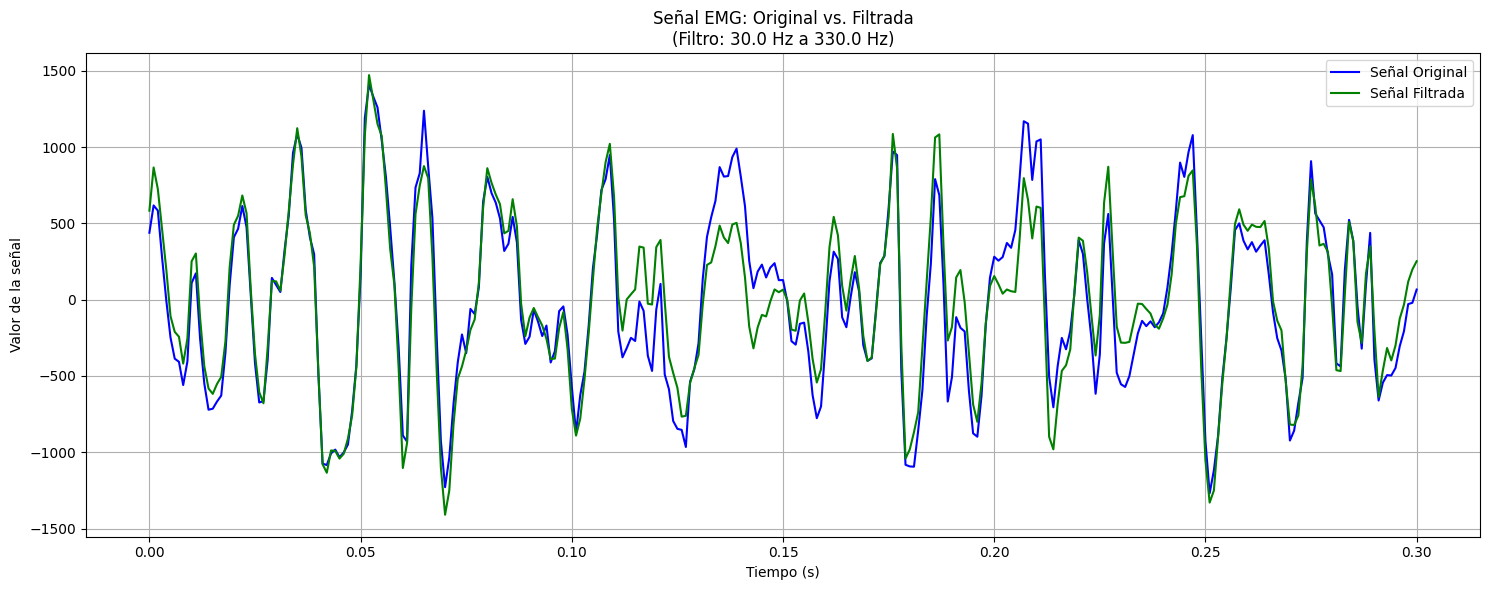

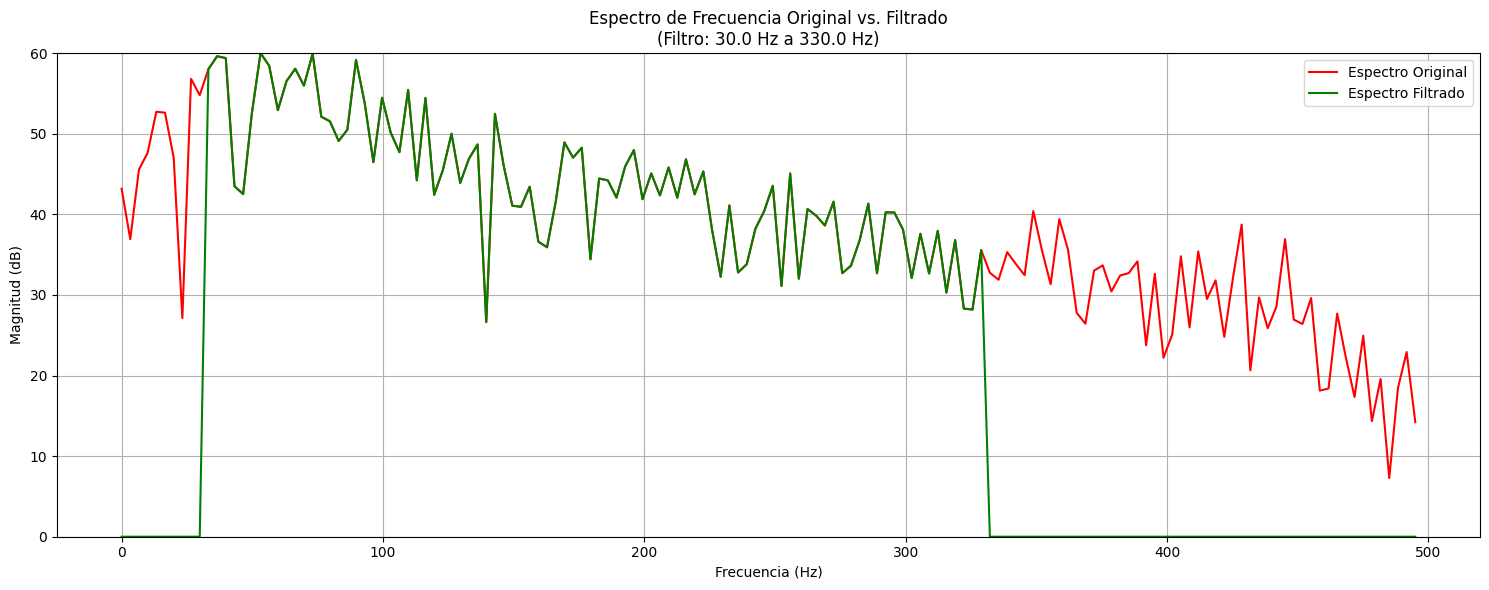

Presiona Enter para continuar con las gráficas de discretización y cuantización...


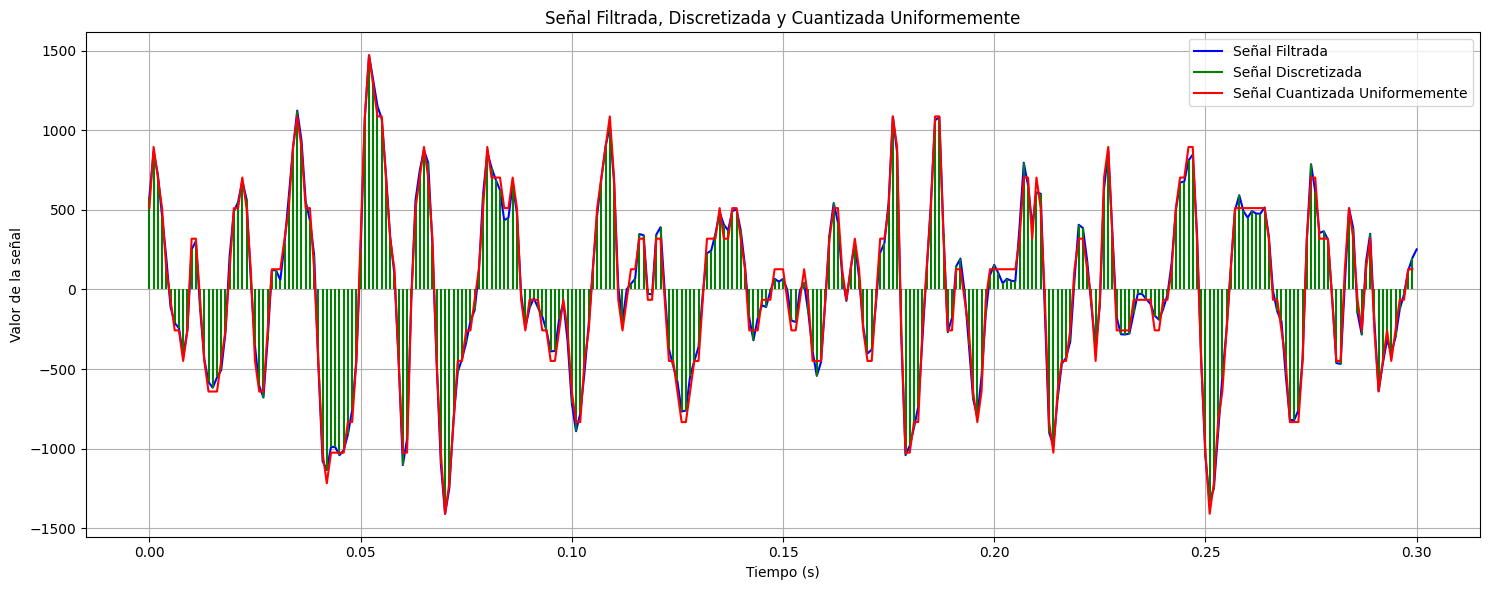

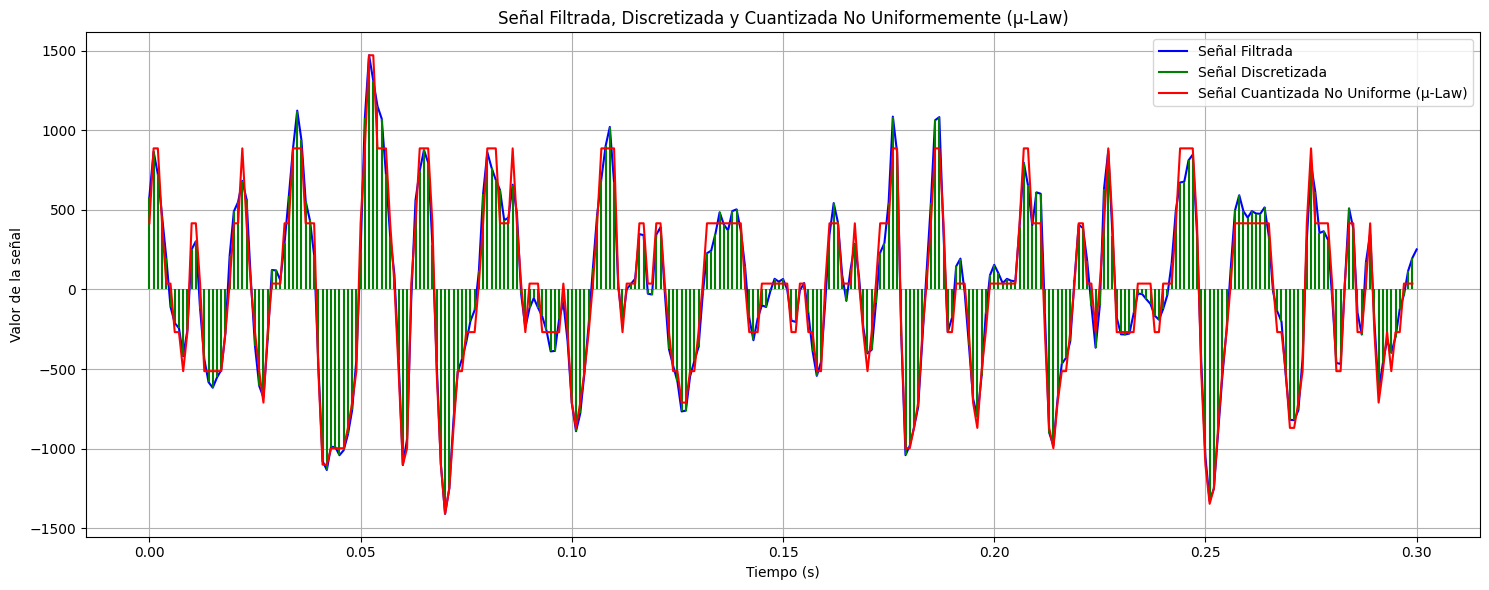

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 301, using nperseg = 301
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 300, using nperseg = 300
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


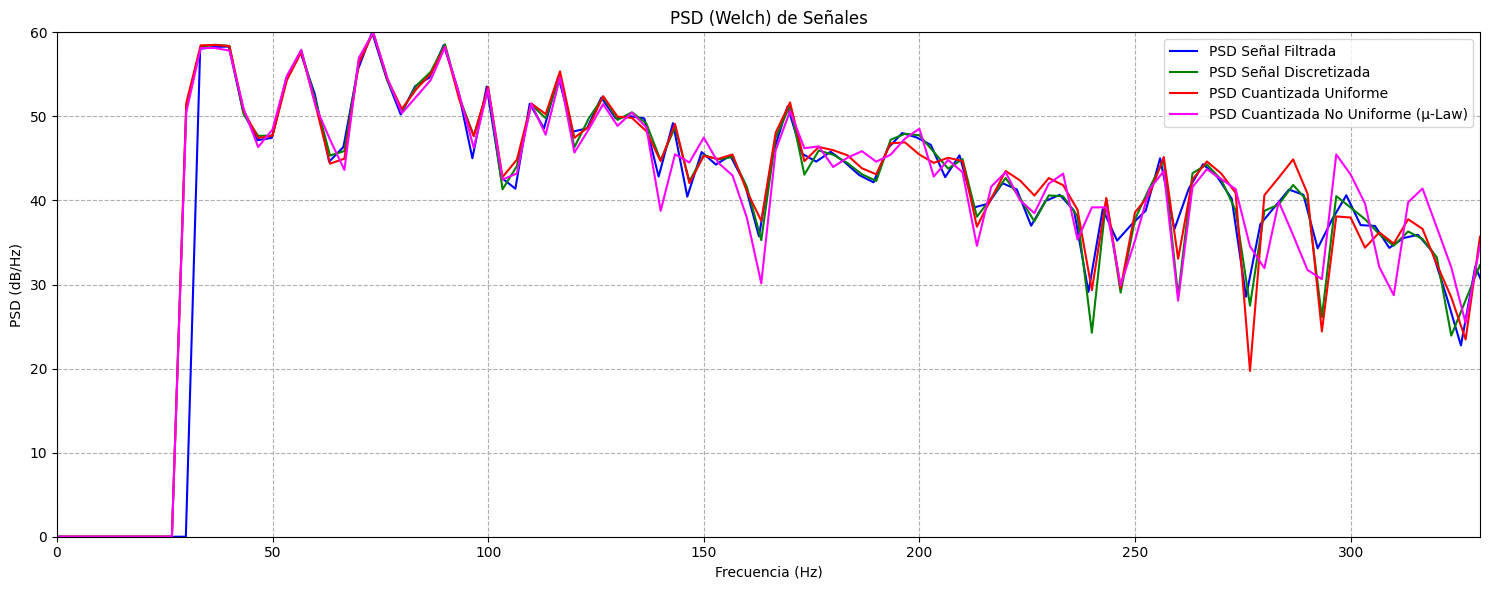

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.fftpack import fft, fftfreq, ifft
from scipy.signal import welch

class SignalProcessor:
    """
    Clase para el procesamiento y visualización de señales EMG a partir de un archivo CSV.

    Esta clase permite:
      - Montar Google Drive y cargar los datos desde un CSV.
      - Filtrar la señal en un intervalo de tiempo especificado.
      - Calcular la Transformada de Fourier (FFT) y aplicar un filtro pasabanda.
      - Discretizar la señal mediante interpolación lineal.
      - Realizar la cuantización de la señal (uniforme y con μ‑Law).
      - Graficar la señal en el dominio del tiempo, el espectro de frecuencia y la Densidad Espectral de Potencia (PSD).
    """

    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        """
        Inicializa la instancia de SignalProcessor.

        Parámetros:
            csv_path (str): Ruta del archivo CSV.
            tiempo_a_graficar (float): Tiempo (en segundos) hasta el cual se procesará la señal.
        """
        self.csv_path = csv_path
        self.tiempo_a_graficar = tiempo_a_graficar

        # Variables que se asignarán durante el procesamiento
        self.tiempo = None
        self.señal = None
        self.tiempo_filtrado = None
        self.señal_filtrada = None
        self.N_filtrado = None
        self.T = None
        self.fs = None
        self.y_f = None
        self.frecuencias = None
        self.f_min = None
        self.f_max = None
        self.y_f_filtrado = None
        self.señal_filtrada_freq = None
        self.sampling_rate = None

    def mount_drive(self):
        """
        Monta Google Drive para acceder a los archivos.

        Utiliza la función drive.mount de Google Colab.
        """
        drive.mount('/content/drive')

    def load_data(self):
        """
        Carga el archivo CSV y filtra los datos según el intervalo de tiempo indicado.

        Se espera que el CSV contenga las columnas:
          - 'Tiempo (ms)' para los instantes de tiempo.
          - 'Datos Columna 2' para los valores de la señal.

        En caso de error (por ejemplo, columnas faltantes o problemas al cargar el archivo),
        el programa se termina.
        """
        try:
            datos = pd.read_csv(self.csv_path)
            print("Archivo CSV cargado exitosamente.")
        except Exception as e:
            print(f"Error al cargar el archivo CSV: {e}")
            exit()

        # Verificar que las columnas requeridas existen
        if 'Tiempo (ms)' in datos.columns and 'Datos Columna 2' in datos.columns:
            # Convertir la columna de tiempo a valores numéricos
            datos['Tiempo (ms)'] = pd.to_numeric(datos['Tiempo (ms)'], errors='coerce')

            # Extraer el tiempo y la señal
            self.tiempo = datos['Tiempo (ms)'].values
            self.señal = datos['Datos Columna 2'].values

            # Filtrar los datos hasta el tiempo especificado
            mask = self.tiempo <= self.tiempo_a_graficar  # Si los tiempos están en ms, ajustar: <= tiempo_a_graficar*1000
            self.tiempo_filtrado = self.tiempo[mask]
            self.señal_filtrada = self.señal[mask]
            self.N_filtrado = len(self.señal_filtrada)
            print(f"Número de puntos en la señal: {self.N_filtrado}")

            # Calcular el intervalo de muestreo medio y la frecuencia de muestreo en Hz
            self.T = np.mean(np.diff(self.tiempo_filtrado))
            self.fs = 1 / self.T
            print(f"Frecuencia de muestreo: {self.fs:.4f} Hz")
        else:
            print("Error: El archivo CSV no contiene las columnas requeridas ('Tiempo (ms)' y 'Datos Columna 2').")
            exit()

    def compute_fft(self):
        """
        Calcula la Transformada de Fourier (FFT) de la señal filtrada.

        Almacena en:
          - self.y_f: La FFT de la señal filtrada.
          - self.frecuencias: El vector de frecuencias asociado.

        Además, imprime las frecuencias mínima y máxima (en valor absoluto) de la señal.
        """
        self.y_f = fft(self.señal_filtrada)
        self.frecuencias = fftfreq(self.N_filtrado, d=self.T)

        # Determinar la frecuencia mínima y máxima (valor absoluto)
        frecuencia_max = np.max(np.abs(self.frecuencias))
        frecuencia_min = np.min(np.abs(self.frecuencias[self.frecuencias > 0])) if np.any(self.frecuencias > 0) else 0
        print(f"Frecuencia mínima de la señal original: {frecuencia_min:.4f} Hz")
        print(f"Frecuencia máxima de la señal original: {frecuencia_max:.4f} Hz")

    def apply_bandpass_filter(self, f_min, f_max):
        """
        Aplica un filtro pasabanda en el dominio de la frecuencia.

        Parámetros:
            f_min (float): Frecuencia mínima (Hz) a dejar pasar.
            f_max (float): Frecuencia máxima (Hz) a dejar pasar.

        Se crea una máscara que conserva únicamente los coeficientes de la FFT
        correspondientes a frecuencias entre f_min y f_max y se aplica la transformada inversa.
        """
        self.f_min = f_min
        self.f_max = f_max
        print(f"Filtro seleccionado: de {f_min} Hz a {f_max} Hz")

        # Crear máscara de filtro
        filtro_mask = (np.abs(self.frecuencias) >= f_min) & (np.abs(self.frecuencias) <= f_max)
        self.y_f_filtrado = self.y_f * filtro_mask

        # Transformada inversa para obtener la señal filtrada en el dominio del tiempo
        self.señal_filtrada_freq = np.real(ifft(self.y_f_filtrado))

    def plot_time_domain(self):
        """
        Grafica la señal original filtrada y la señal filtrada (tras aplicar el filtro en frecuencia)
        en el dominio del tiempo.
        """
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada, color='b', label='Señal Original')
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, color='g', label='Señal Filtrada')
        plt.title(f'Señal EMG: Original vs. Filtrada\n(Filtro: {self.f_min} Hz a {self.f_max} Hz)')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Valor de la señal')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_frequency_spectrum(self):
        """
        Grafica el espectro de Fourier de la señal original y la señal filtrada.

        El espectro se muestra en escala dB y se normaliza para que el máximo sea 60 dB.
        Se utilizan únicamente las frecuencias positivas.
        """
        eps = 1e-12  # Pequeño valor para evitar log(0)
        # Calcular espectro en dB (solo mitad positiva)
        espectro_original_db = 20 * np.log10(np.abs(self.y_f[:self.N_filtrado // 2]) + eps)
        espectro_filtrado_db = 20 * np.log10(np.abs(self.y_f_filtrado[:self.N_filtrado // 2]) + eps)

        # Normalizar: ajustar el máximo a 60 dB
        norm_factor = np.max(espectro_original_db)
        espectro_original_db_norm = np.clip(espectro_original_db - norm_factor + 60, 0, 60)
        espectro_filtrado_db_norm = np.clip(espectro_filtrado_db - norm_factor + 60, 0, 60)

        plt.figure(figsize=(15, 6))
        plt.plot(self.frecuencias[:self.N_filtrado // 2], espectro_original_db_norm, color='r', label='Espectro Original')
        plt.plot(self.frecuencias[:self.N_filtrado // 2], espectro_filtrado_db_norm, color='g', label='Espectro Filtrado')
        plt.title(f'Espectro de Frecuencia Original vs. Filtrado\n(Filtro: {self.f_min} Hz a {self.f_max} Hz)')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Magnitud (dB)')
        plt.ylim(0, 60)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def discretize_signal(self, sampling_rate=1000):
        """
        Discretiza la señal filtrada utilizando interpolación lineal.

        Parámetros:
            sampling_rate (int): Frecuencia de muestreo deseada (Hz) para la discretización.

        Retorna:
            tuple: (tiempo_discreto, señal_filtrada_discreta) donde:
              - tiempo_discreto (np.array): Vector de tiempo para la señal discretizada.
              - señal_filtrada_discreta (np.array): Señal discretizada.
        """
        self.sampling_rate = sampling_rate
        sampling_period = 1 / sampling_rate
        tiempo_discreto = np.arange(self.tiempo_filtrado[0], self.tiempo_filtrado[-1], sampling_period)
        señal_filtrada_discreta = np.interp(tiempo_discreto, self.tiempo_filtrado, self.señal_filtrada_freq)
        return tiempo_discreto, señal_filtrada_discreta

    @staticmethod
    def quantize_uniform(x, q_min, q_max, q_level):
        """
        Realiza la cuantización uniforme de una señal.

        Parámetros:
            x (np.array): Señal de entrada.
            q_min (float): Valor mínimo de la señal para la cuantización.
            q_max (float): Valor máximo de la señal para la cuantización.
            q_level (int): Número de niveles de cuantización.

        Retorna:
            np.array: Señal cuantizada de forma uniforme.
        """
        x_normalize = (x - q_min) * (q_level - 1) / (q_max - q_min)
        x_normalize = np.clip(x_normalize, 0, q_level - 1)
        x_quant = np.round(x_normalize) * (q_max - q_min) / (q_level - 1) + q_min
        return x_quant

    @staticmethod
    def quantize_mu_law(signal, L=16, mu=255, x_min=None, x_max=None):
        """
        Realiza la cuantización no uniforme utilizando la companding μ‑Law.

        Parámetros:
            signal (np.array): Señal de entrada.
            L (int): Número de niveles de cuantización (por defecto 16).
            mu (int): Factor de companding (por defecto 255).
            x_min (float): Valor mínimo de la señal; si es None, se calcula a partir de la señal.
            x_max (float): Valor máximo de la señal; si es None, se calcula a partir de la señal.

        Retorna:
            np.array: Señal cuantizada de forma no uniforme utilizando la ley μ‑Law.
        """
        if x_min is None:
            x_min = signal.min()
        if x_max is None:
            x_max = signal.max()
        x_norm = (signal - x_min) / (x_max - x_min)
        companded = np.log1p(mu * x_norm) / np.log1p(mu)
        q_companded = np.round(companded * (L - 1)) / (L - 1)
        q_nonuniform = (np.expm1(q_companded * np.log1p(mu)) / mu) * (x_max - x_min) + x_min
        return q_nonuniform

    def plot_discretized_quantized(self, tiempo_discreto, señal_filtrada_discreta, señal_quant_uniform):
        """
        Grafica la señal filtrada, su versión discretizada y la cuantizada de forma uniforme.

        Parámetros:
            tiempo_discreto (np.array): Vector de tiempo discreto obtenido en la discretización.
            señal_filtrada_discreta (np.array): Señal discretizada.
            señal_quant_uniform (np.array): Señal cuantizada uniformemente.
        """
        plt.figure(figsize=(15, 6))
        # Señal filtrada continua en azul
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Señal Filtrada')

        # Señal discretizada mostrada con stem en verde (sin marcadores ni línea base)
        markerline, stemlines, baseline = plt.stem(
            tiempo_discreto,
            señal_filtrada_discreta,
            linefmt='g-',
            markerfmt=' ',
            basefmt=' '
        )
        baseline.set_visible(False)
        plt.plot([], [], 'g-', label='Señal Discretizada')

        # Señal cuantizada uniformemente en rojo
        plt.plot(tiempo_discreto, señal_quant_uniform, 'r-', label='Señal Cuantizada Uniformemente')

        plt.xlabel('Tiempo (s)')
        plt.ylabel('Valor de la señal')
        plt.title('Señal Filtrada, Discretizada y Cuantizada Uniformemente')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_quantized_mu(self, tiempo_discreto, señal_quant_mu, señal_filtrada_discreta):
        """
        Grafica la señal filtrada, discretizada y la cuantizada con la ley μ‑Law.

        Parámetros:
            tiempo_discreto (np.array): Vector de tiempo discreto obtenido en la discretización.
            señal_quant_mu (np.array): Señal cuantizada con la ley μ‑Law.
            señal_filtrada_discreta (np.array): Señal discretizada.
        """
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Señal Filtrada')
        markerline, stemlines, baseline = plt.stem(
            tiempo_discreto,
            señal_filtrada_discreta,
            linefmt='g-',
            markerfmt=' ',
            basefmt=' '
        )
        baseline.set_visible(False)
        plt.plot([], [], 'g-', label='Señal Discretizada')
        plt.plot(tiempo_discreto, señal_quant_mu, 'r-', label='Señal Cuantizada No Uniforme (μ‑Law)')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Valor de la señal')
        plt.title('Señal Filtrada, Discretizada y Cuantizada No Uniformemente (μ‑Law)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_psd(self, tiempo_discreto, señal_filtrada_discreta, señal_quant_uniform, señal_quant_mu, eps=1e-12):
        """
        Grafica la Densidad Espectral de Potencia (PSD) para diversas versiones de la señal utilizando el método de Welch.

        Se calculan y normalizan las PSD para:
          - La señal filtrada (usando la frecuencia de muestreo original).
          - La señal discretizada.
          - La señal cuantizada uniformemente.
          - La señal cuantizada no uniformemente (μ‑Law).

        Parámetros:
            tiempo_discreto (np.array): Vector de tiempo discreto.
            señal_filtrada_discreta (np.array): Señal discretizada.
            señal_quant_uniform (np.array): Señal cuantizada uniformemente.
            señal_quant_mu (np.array): Señal cuantizada con μ‑Law.
            eps (float): Valor pequeño para evitar log(0) (por defecto 1e-12).
        """
        # PSD para la señal filtrada (frecuencia de muestreo original fs)
        f_welch_filt, psd_welch_filt = welch(self.señal_filtrada_freq, self.fs, nperseg=1024)
        psd_db_filt = 10 * np.log10(psd_welch_filt + eps)
        norm_factor_filt = np.max(psd_db_filt)
        psd_db_norm_filt = np.clip(psd_db_filt - norm_factor_filt + 60, 0, 60)

        # PSD para la señal discretizada y cuantizada (sampling_rate = self.sampling_rate)
        f_welch_disc, psd_welch_disc = welch(señal_filtrada_discreta, self.sampling_rate, nperseg=1024)
        psd_db_disc = 10 * np.log10(psd_welch_disc + eps)
        norm_factor_disc = np.max(psd_db_disc)
        psd_db_norm_disc = np.clip(psd_db_disc - norm_factor_disc + 60, 0, 60)

        f_welch_qunif, psd_welch_qunif = welch(señal_quant_uniform, self.sampling_rate, nperseg=1024)
        psd_db_qunif = 10 * np.log10(psd_welch_qunif + eps)
        norm_factor_qunif = np.max(psd_db_qunif)
        psd_db_norm_qunif = np.clip(psd_db_qunif - norm_factor_qunif + 60, 0, 60)

        f_welch_qmu, psd_welch_qmu = welch(señal_quant_mu, self.sampling_rate, nperseg=1024)
        psd_db_qmu = 10 * np.log10(psd_welch_qmu + eps)
        norm_factor_qmu = np.max(psd_db_qmu)
        psd_db_norm_qmu = np.clip(psd_db_qmu - norm_factor_qmu + 60, 0, 60)

        def plot_psd_zeroed(frequencies, psd_values, label, color, f_min):
            """
            Función auxiliar para asignar 0 a los valores de PSD para frecuencias menores a f_min y graficarlos.

            Parámetros:
                frequencies (np.array): Vector de frecuencias.
                psd_values (np.array): Valores de la PSD en dB.
                label (str): Etiqueta para la leyenda.
                color (str): Color de la línea en la gráfica.
                f_min (float): Frecuencia mínima a partir de la cual se muestra la PSD.
            """
            psd_zeroed = psd_values.copy()
            psd_zeroed[frequencies < f_min] = 0
            plt.plot(frequencies, psd_zeroed, color=color, label=label)

        plt.figure(figsize=(15, 6))
        plot_psd_zeroed(f_welch_filt, psd_db_norm_filt, 'PSD Señal Filtrada', 'blue', self.f_min)
        plot_psd_zeroed(f_welch_disc, psd_db_norm_disc, 'PSD Señal Discretizada', 'green', self.f_min)
        plot_psd_zeroed(f_welch_qunif, psd_db_norm_qunif, 'PSD Cuantizada Uniforme', 'red', self.f_min)
        plot_psd_zeroed(f_welch_qmu, psd_db_norm_qmu, 'PSD Cuantizada No Uniforme (μ‑Law)', 'magenta', self.f_min)
        plt.title('PSD (Welch) de Señales')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xlim(0, self.f_max)
        plt.ylim(0, 60)
        plt.grid(True, which='both', ls='--')
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    """
    Función principal que orquesta el procesamiento y la visualización de la señal.

    Flujo de ejecución:
      1. Se crea una instancia de SignalProcessor con la ruta del CSV y el tiempo a graficar.
      2. Se monta Google Drive y se cargan los datos.
      3. Se calcula la FFT y se solicitan al usuario los parámetros del filtro pasabanda.
      4. Se aplica el filtro y se muestran las gráficas en el dominio del tiempo y en frecuencia.
      5. Tras presionar Enter, se procede a la discretización y cuantización de la señal,
         mostrando las gráficas correspondientes (discretización, cuantización uniforme y μ‑Law, y PSD).
    """
    # Ruta del archivo CSV (modificar según corresponda)
    csv_path = "/content/drive/MyDrive/Signal Theory/Running_Columna_2_Tiempo.csv"

    # Crear instancia del procesador de señales (se procesan 0.3 s de señal)
    sp = SignalProcessor(csv_path, tiempo_a_graficar=0.3)

    # Montar Google Drive y cargar los datos
    sp.mount_drive()
    sp.load_data()
    sp.compute_fft()

    # Solicitar al usuario las frecuencias para el filtro
    try:
        f_min = float(input("Ingresa la frecuencia mínima (Hz) a filtrar: "))
        f_max = float(input("Ingresa la frecuencia máxima (Hz) a filtrar: "))
    except Exception as e:
        print("Error al ingresar los valores de frecuencia:", e)
        exit()

    # Aplicar el filtro pasabanda
    sp.apply_bandpass_filter(f_min, f_max)

    # -------------------------------------------------------------------
    # Bloque 1: Gráficas iniciales (dominio del tiempo y espectro de Fourier)
    # -------------------------------------------------------------------
    sp.plot_time_domain()
    sp.plot_frequency_spectrum()

    # Espera para continuar (permite ver las dos primeras gráficas antes de proceder)
    input("Presiona Enter para continuar con las gráficas de discretización y cuantización...")

    # -------------------------------------------------------------------
    # Bloque 2: Procesamiento adicional: discretización y cuantización
    # -------------------------------------------------------------------
    # Discretización de la señal filtrada (nuevo muestreo a 1000 Hz)
    tiempo_discreto, señal_filtrada_discreta = sp.discretize_signal(sampling_rate=1000)

    # Definir el número de niveles para la cuantización (16 niveles -> 4 bits)
    num_bits = 4
    levels_uniforme = 2 ** num_bits
    q_min_val = np.min(señal_filtrada_discreta)
    q_max_val = np.max(señal_filtrada_discreta)

    # Cuantización uniforme
    señal_quant_uniform = sp.quantize_uniform(señal_filtrada_discreta, q_min_val, q_max_val, levels_uniforme)

    # Cuantización no uniforme utilizando la ley μ‑Law (en este ejemplo se usa mu=25)
    señal_quant_mu = sp.quantize_mu_law(señal_filtrada_discreta, L=levels_uniforme, mu=25)

    # -------------------------------------------------------------------
    # Bloque 3: Graficación de discretización y cuantización
    # -------------------------------------------------------------------
    # Gráfica 3: Señal filtrada, discretizada y cuantizada uniformemente
    sp.plot_discretized_quantized(tiempo_discreto, señal_filtrada_discreta, señal_quant_uniform)

    # Gráfica 4: Señal filtrada, discretizada y cuantizada no uniformemente (μ‑Law)
    sp.plot_quantized_mu(tiempo_discreto, señal_quant_mu, señal_filtrada_discreta)

    # Gráfica 5: PSD (Welch) para las señales
    sp.plot_psd(tiempo_discreto, señal_filtrada_discreta, señal_quant_uniform, señal_quant_mu)

if __name__ == "__main__":
    main()
